# Monte Carlos simulation for the average of the third and fourth order cumulants

We will always assume that $\bar{n}=1$ for squeezed, squashed and lossy squeezed states.

For squeezed states, $\bar{m}=\sqrt{\bar{n}(\bar{n}+1)}=\sqrt{2}$

For squashed states, $\bar{m} = \bar{n}= 1$

For lossy squeezed states, $\eta=\tfrac{1}{2}$, $\bar{n}=2$. Which becomes $\bar{n}^{\prime}=\eta\bar{n}=1$ and $\bar{m}^{\prime}=\eta\sqrt{\bar{n}(\bar{n}+1)}=\sqrt{\tfrac{3}{2}}$

For thermal states, $\bar{m} = 0$

Also,
$N_{out} = U^*N_{in}U^T$ and $M_{out} = UM_{in}U^T$

In [34]:
from scipy.stats import unitary_group
from numpy import identity, zeros, block, eye, vstack, absolute
import numpy as np
import matplotlib.pyplot as plt
from time import time

Needed modification :
1. DONE Make the function vectorial so that it does all 4 states at one (inputs $n$ and $m$ would then be arrays of size 4). $n=(1, 1, 1, 1)$, $m=(1, \sqrt{2},  \sqrt{3/2},  0)$.

2. DONE The cumulant functions only a tiny fraction of the full matrices $N$ and $M$. Make sure that the following is equivalent and then use the right side of the equation to reduce the exectution time drastically.

$np.allclose((n*UC[,0:k] @ UT[,0:k])[0:order], n*UC[0:order,0:k] @ UT[0:order,0:k])$ 

3. DONE I curently output the mean and the std, also output the skewness of the cumulant since it is free real estate.

$\tilde{\mu}_3 = \frac {E[x^3]-3\mu\sigma^2-\mu^3}{\sigma^3}$ 

4. Make sure that the current method doesn't have rounding errors. Towards the last trials, we are starting to add small number to a really large one. There is always that possibility that at one point, the sum is not done du to truncature errors.

5. DONE Make these changes in a new function and compare the running times. 

6. Shift the std on the graph based on the skewness.

7. Look at how to profile code in python. This will help find the greediest parts of the code in terms of time to see where our energy should go.

8. Manage the division by zero in the skewness calculation.

In [35]:
def cumulant_second_order(N,M):
    return absolute(M[0,1])**2+absolute(N[0,1])**2

def cumulant_third_order(N,M):
    result = M[0,2].conj()*M[0,1]*N[1,2] \
        +M[1,2].conj()*M[0,1]*N[0,2] \
            +M[1,2].conj()*M[0,2]*N[0,1] \
                +N[0,2].conj()*N[0,1]*N[1,2]
    return 2*result.real

def cumulant_fourth_order(N,M):
    result = M[0,2].conj()*M[1,3].conj()*M[0,1]*M[2,3] + M[0,2].conj()*N[2,3].conj()*M[0,1]*N[1,3] \
        + M[0,3].conj()*M[1,2].conj()*M[0,1]*M[2,3] + M[0,3].conj()*M[1,2].conj()*M[0,2]*M[1,3] \
            + M[0,3].conj()*N[1,2].conj()*M[0,2]*N[1,3] + M[0,3].conj()*M[0,1]*N[1,2]*N[2,3] \
                + M[1,2].conj()*N[1,3].conj()*M[0,2]*N[0,3] + M[1,2].conj()*N[1,3].conj()*M[0,3]*N[0,2] \
                    + M[1,2].conj()*N[2,3].conj()*M[0,1]*N[0,3] + M[1,2].conj()*N[2,3].conj()*M[0,3]*N[0,1] \
                        + M[1,3].conj()*N[0,2].conj()*M[1,2]*N[0,3] + M[1,3].conj()*N[1,2].conj()*M[0,2]*N[0,3] \
                            + M[1,3].conj()*N[1,2].conj()*M[0,3]*N[0,2] + M[1,3].conj()*M[0,1]*N[0,2]*N[2,3] \
                                + M[1,3].conj()*M[0,2]*N[0,1]*N[2,3] + M[2,3].conj()*N[0,1].conj()*M[1,2]*N[0,3] \
                                    + M[2,3].conj()*N[0,1].conj()*M[1,3]*N[0,2] + M[2,3].conj()*M[0,1]*N[0,2]*N[1,3] \
                                        + M[2,3].conj()*M[0,1]*N[0,3]*N[1,2] + M[2,3].conj()*M[0,2]*N[0,1]*N[1,3] \
                                            + M[2,3].conj()*M[0,3]*N[0,1]*N[1,2] + N[0,2].conj()*N[2,3].conj()*N[0,1]*N[1,3] \
                                                + N[0,3].conj()*N[1,2].conj()*N[0,2]*N[1,3] + N[0,3].conj()*N[0,1]*N[1,2]*N[2,3]
    return 2*result.real

def cumulant(N,M, order):
    if order== 2:
        result = cumulant_second_order(N,M)
    elif order == 3:
        result = cumulant_third_order(N,M)
    elif order == 4:
        result = cumulant_fourth_order(N,M)    
    return result

def mc_cumulant(n, m, l, trials, order):
    mc_order1 = zeros(l+1, np.float64)
    mc_order2 = zeros(l+1, np.float64)
    mc_order3 = zeros(l+1, np.float64)
    for i in range(trials):
        U = unitary_group.rvs(l)
        UT = U.T #to transpose only once
        UC = U.conj() #conjugate only once
        mc_row = np.empty(l+1, np.float64)
        mc_row[0] = 0 #cumulant is 0 for K=0
        #no rows deleted for K=l
        N = n*UC @ UT
        M = m*U @ UT
        mc_row[l] = cumulant(N,M, order)

        for k in range(l-1,0,-1):
            UT[k] = 0 # N_in @ UT simply remove the l-k last rows of UT
            N = n*UC @ UT
            M = m*U @ UT
            mc_row[k] = cumulant(N,M, order)
        mc_order1 += mc_row
        mc_order2 += mc_row**2
        mc_order3 += mc_row**3
    mc_mean = mc_order1/trials
    mc_std = np.sqrt(mc_order2/trials-mc_mean**2)
    mc_skweness = (mc_order3-3*mc_mean*mc_std**2-mc_mean**3)/mc_std**3
    return mc_mean, mc_std

def mc_cumulant_faster(n, m, l, trials, order):
    assert len(n)==len(m), 'n and m should have the same size'
    assert l >= order, 'l should be at least equal to the order of the cumulant.'
    size = len(n)
    mc_order1 = zeros((l+1,size), np.float64)
    mc_order2 = zeros((l+1,size), np.float64)
    mc_order3 = zeros((l+1,size), np.float64)
    for i in range(trials):
        U = unitary_group.rvs(l)
        UT = U.T #to transpose only once
        UC = U.conj() #conjugate only once
        mc_trial = np.empty((l+1,size), np.float64)
        mc_trial[0] = 0 #cumulant is 0 for K=0

        for k in range(1, l+1):
            N = UC[:order,:k] @ UT[:k,:order]
            M = U[:order,:k] @ UT[:k,:order]
            for p, q, r in zip(n,m, range(size)):
                mc_trial[k,r] = cumulant(p*N, q*M, order)

        mc_order1 += mc_trial
        mc_order2 += mc_trial**2
        mc_order3 += mc_trial**3
    
    #THE SKEWNESS DIVISION BY ZERO STILL NEED TO BE MANAGED
    mc_mean = mc_order1/trials
    mc_std = np.sqrt(mc_order2/trials-mc_mean**2)
    mc_skewness = (mc_order3-3*mc_mean*mc_std**2-mc_mean**3)#/mc_std**3
    return mc_mean, mc_std, mc_skewness


Testing against the second order for which we already have a plot that we can use to validate the current code.

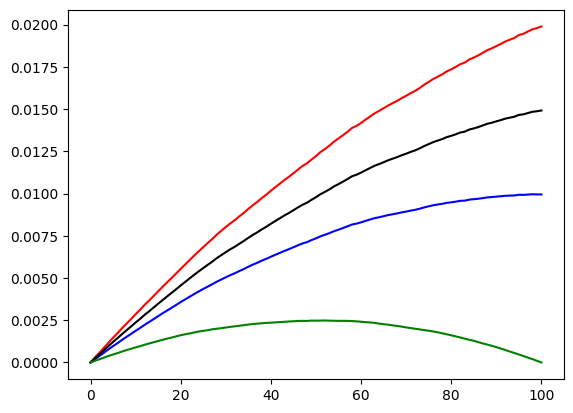

In [39]:
n = [1,1,1,1]
m = [np.sqrt(2), 1, np.sqrt(3/2), 0]
l = 100
trials = 10000
order = 2

U = unitary_group.rvs(l)
UT = U.T #to transpose only once
UC = U.conj() #conjugate only once

test = mc_cumulant_faster(n, m, l, trials, order)

k = list(range(l+1))

fig, ax = plt.subplots()
ax.plot(k, test[0][:,0], color='r', label = r'Squeezed')
ax.plot(k, test[0][:,1], color='b', label = r'Squashed')
ax.plot(k, test[0][:,2], color='k', label = r'Lossy squeezed')
ax.plot(k, test[0][:,3], color='g', label = r'Thermal')

Speed testing

In [38]:
n = [1,1,1,1]
m = [np.sqrt(2), 1, np.sqrt(3/2), 0]
l = 100
trials = 1000
order = 3

toc = time()
fast = mc_cumulant_faster(n, m, l, trials, order)
tic = time()
fast_time = tic-toc
print(f'Faster algorithm time : {round(fast_time,0)}')

toc = time()
for i,j in zip(n,m):
    slow = mc_cumulant(i, j ,l, trials, order)
tic = time()
slow_time = tic-toc
print(f'Slower algorithm time : {round(slow_time,0)}')
print(f'Speed up ratio : {round(slow_time/fast_time,1)}, for a {trials} trials test.')

Faster algorithm time : 12.479074478149414


C:\Users\yanic\AppData\Local\Temp\ipykernel_7972\4213414490.py:60: RuntimeWarning: invalid value encountered in divide
  mc_skweness = (mc_order3-3*mc_mean*mc_std**2-mc_mean**3)/mc_std**3


Slower algorithm time : 155.9894895553589
Speed up ratio : 0.1, for a 1000 trials test.


Plots

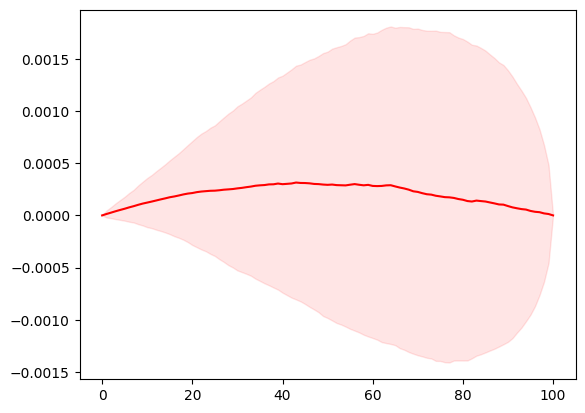

In [7]:
n = [1,1,1,1]
m = [np.sqrt(2), 1, np.sqrt(3/2), 0] #squeezed, squashed, lossy squeezed, thermal
l = 100
trials = 1000
order = 3
k = list(range(l+1))

cumulant = mc_cumulant_faster(n, m, l, trials, order)

fig, ax = plt.subplots()
ax.plot(k, test[0][:,0], color='r', label = r'Squeezed')
ax.plot(k, test[0][:,1], color='b', label = r'Squashed')
ax.plot(k, test[0][:,2], color='k', label = r'Lossy squeezed')
ax.plot(k, test[0][:,3], color='g', label = r'Thermal')
#ax.fill_between(k, squeezed_mean-squeezed_std, squeezed_mean+squeezed_std, alpha=0.1, color='r')
plt.savefig('C:/Users/yanic/w_Poly/22T2_Stage_BosonSampling/_Montrealer/z_overleaf_archive/cumulant_fuckery/test_2409.pdf')  
